### Imports

In [1]:
import os
import numpy as np
import trimesh
import random
import math
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import keras.models

from PIL import Image
from random import seed
from random import random
from sklearn.decomposition import PCA

### Read data

In [17]:
def read_off(file):
    return trimesh.load(file).sample(8192)


def plot3D(data):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(data[:, 0], data[:, 1], data[:, 2])
    ax.view_init(30, 200)


def plot2DBW(data):
    plt.imshow(data[1],'gray')
    plt.show()

In [3]:
categories = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]

train_data = []
test_data = []

path = './ModelNet10/'

current = 0

for category in categories:

    files_train = os.listdir(path + category + "/train")

    for f in files_train:
        train_data.append((category, read_off(path + category + "/train/" + f)))
        current += 1
        if current % 100 == 0:
            print(current)

    files_test = os.listdir(path + category + "/test")

    for f in files_test:
        test_data.append((category, read_off(path + category + "/test/" + f)))
        current += 1
        if current % 100 == 0:
            print(current)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


### Normalize

In [4]:
def normalize(train_data):
    current = 0
    normalizedSize = 240
    new_train_data = []

    maxXReal = 0
    maxYReal = 0
    maxZReal = 0

    for model in train_data:
        minX = 123123123
        minY = 123123123
        minZ = 123123123
        maxX = -123123123
        maxY = -123123123
        maxZ = -123123123

        for point in model[1]:
            minX = min(minX, point[0])
            minY = min(minY, point[1])
            minZ = min(minZ, point[2])
            maxX = max(maxX, point[0])
            maxY = max(maxY, point[1])
            maxZ = max(maxZ, point[2])

        result = []

        if maxX - minX >= maxY - minY and maxX - minX >= maxZ - minZ:
            divRatio = maxX - minX
        elif maxY - minY >= maxX - minX and maxY - minY >= maxZ - minZ:
            divRatio = maxY - minY
        else:
            divRatio = maxZ - minZ

        for point in model[1]:
            newX = ((point[0] - minX) / divRatio) * normalizedSize
            newY = ((point[1] - minY) / divRatio) * normalizedSize
            newZ = ((point[2] - minZ) / (maxZ - minZ)) * normalizedSize

            maxXReal = max(maxXReal, newX)
            maxYReal = max(maxYReal, newY)
            maxZReal = max(maxZReal, newZ)

            result.append(np.array([newX, newY, newZ]))

            # print(str(point[0]) + " + " + str(point[1]) + " + " + str(point[2]))

        new_train_data.append((model[0], np.array(result)))

        current += 1

        if current % 100 == 0:
            print(current)

        # print(str(minX) + " + " + str(maxX))
    return new_train_data

In [5]:
train_data_n = normalize(train_data)
test_data_n = normalize(test_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


### Process the data ( 2D simple slicing )

In [55]:
def changeView(data):
    current = 0
    normalizedSize = 240
    images = []

    for model in data:
        slices = np.zeros((normalizedSize*4, normalizedSize*4), 'uint8')
        for point in model[1]:
            point_slice = int((point[2] - 0.001) / 15)
            i = int(point_slice / 4)
            j = int(point_slice % 4)
            targetI = int(point[0] - 0.01 + i * normalizedSize)
            targetJ = int(point[1] - 0.01 + j * normalizedSize)
            for nextI in range(3):
                for nextJ in range(3):
                    goI = targetI + nextI - 1
                    goJ = targetJ + nextJ - 1

                    if goI < 0 or goI >= 4*normalizedSize or goJ < 0 or goJ >= 4*normalizedSize:
                        continue

                    slices[goI, goJ] = 1
        images.append((model[0], slices))
        current += 1
        if current % 100 == 0:
            print(current)

    return images

In [7]:
train_images = changeView(train_data_n)
test_images = changeView(test_data_n)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


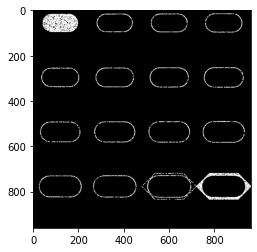

In [50]:
plot2DBW(train_images[3])

### Process the data ( 2D multiaxis slicing )

In [175]:
def changeViewRGB(data):
    current = 0
    normalizedSize = 240
    images = []

    for model in data:
        slices = np.zeros((3, normalizedSize, normalizedSize, 3), 'uint8')
        dividend = int(255/4)
        for point in model[1]:
            point_slice_x = int((point[0] - 0.001) / 20)
            point_slice_y = int((point[1] - 0.001) / 20)
            point_slice_z = int((point[2] - 0.001) / 20)
            i = int(point_slice_x / 4)
            j = int(point_slice_y / 4)
            k = int(point_slice_z / 4)
            for nextI in range(3):
                for nextJ in range(3):

                    goI = int(point[0] + nextI - 1 - 0.01)
                    goJ = int(point[1] + nextJ - 1 - 0.01)

                    if 0 <= goI < normalizedSize and 0 <= goJ < normalizedSize:
                        slices[0, goI, goJ, k] += dividend

                    goI = int(point[0] + nextI - 1 - 0.01)
                    goJ = int(point[2] + nextJ - 1 - 0.01)

                    if 0 <= goI < normalizedSize and 0 <= goJ < normalizedSize:
                        slices[1, goI, goJ, j] += dividend

                    goI = int(point[1] + nextI - 1 - 0.01)
                    goJ = int(point[2] + nextJ - 1 - 0.01)

                    if 0 <= goI < normalizedSize and 0 <= goJ < normalizedSize:
                        slices[2, goI, goJ, i] += dividend

                    #slices[int(point[0] - 0.01), int(point[1] - 0.01), i] |= (3 << (2 * j))


        images.append((model[0], slices))
        current += 1
        if current % 100 == 0:
            print(current)

    return images

In [176]:
train_images_rgb = changeViewRGB(train_data_n)
test_images_rgb = changeViewRGB(test_data_n)

In [177]:
def combineToSinglePicture(data):
    images = []
    normalizedSize = 240
    for image in data:
        slices = np.zeros((normalizedSize, normalizedSize*3 + 200, 3), 'uint8')
        slices[:, 0:normalizedSize,:] = image[1][0,:,:]
        slices[:, normalizedSize + 100:2*normalizedSize + 100,:] = image[1][1,:,:]
        slices[:, 2*normalizedSize + 200: 3*normalizedSize + 200,:] = image[1][2,:,:]
        images.append((image[0], slices))
    return images

In [178]:
train_images_rgb_combined = combineToSinglePicture(train_images_rgb)
test_images_rgb_combined = combineToSinglePicture(test_images_rgb)

bathtub


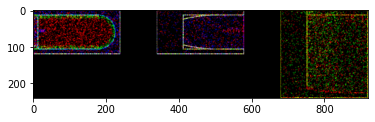

In [190]:
index = 15
print(train_images_rgb_combined[index][0])
plt.imshow(train_images_rgb_combined[index][1])
plt.show()

### Prepare to feed to the model

In [71]:
train_final = np.array([i[1] for i in train_images])
train_labels = np.array([categories.index(l) for l in [i[0] for i in train_images]])

/tmp/ipykernel_126482/3398517217.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_final = np.array([i[1] for i in train_images])


In [72]:
test_final = np.array([i[1] for i in test_images])
test_labels = np.array([categories.index(l) for l in [i[0] for i in test_images]])

/tmp/ipykernel_126482/2808246889.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_final = np.array([i[1] for i in test_images])


In [78]:
train_final[0].shape

(1184, 3, 2)

### The Model

In [79]:
model = tf.keras.Sequential([
    # tf.keras.layers.Conv2D(60, kernel_size=(3, 3), input_shape=(240*4, 240*4, 1)),
    # tf.keras.layers.MaxPool2D(pool_size=(8, 8)),
    # tf.keras.layers.Conv2D(60, kernel_size=(3, 3)),
    # tf.keras.layers.MaxPool2D(pool_size=(8, 8)), # !!! 2 2
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

2022-01-14 18:55:31.742578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 18:55:31.742846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 18:55:31.742898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-14 18:55:31.742940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-14 18:55:31.742981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [82]:
model.fit(train_final, train_labels, epochs=40)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [65]:
test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

29/29 - 0s - loss: 4.4401 - accuracy: 0.1112 - 81ms/epoch - 3ms/step

Test accuracy: 0.11123348027467728


#### Step by step fit

In [ ]:
i = 0

In [ ]:
while 1:
    i += 1
    print(i)
    print(train_final.shape, train_labels.shape)
    model.fit(train_final, train_labels, epochs=1)
    test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)
    print('Test accuracy:', test_acc, '\n')

In [ ]:
test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)
print('Test accuracy:', test_acc, '\n')

#### Save the model

In [ ]:
model.save("third.h5")
np.save('train_final_third.npy', train_final)
np.save('test_final_third.npy', test_final)
np.save('train_labels_third.npy', train_labels)
np.save('test_labels_third.npy', test_labels)

#### Load the model

In [ ]:
model = keras.models.load_model("third.h5")
train_final = np.load("train_final_third.npy")
test_final = np.load("test_final_third.npy")
train_labels = np.load("train_labels_third.npy")
test_labels = np.load("test_labels_third.npy")